# Regular Classification with 7 Classes

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import warnings
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# os.chdir('notebooks/Documents/GitHub/GENG5551-Akida-Chip')
os.getcwd()

'c:\\Users\\Joo_Kai\\Documents\\GitHub\\GENG5551-Akida-Chip'

In [3]:
from tensorflow.keras.models import load_model
from akida_models import load_model


model_path = 'model_akida.fbz'
model = load_model(model_path)

model.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 7]     1          14    
______________________________________________

_________________________________________________________
Layer (type)           Output shape   Kernel shape     

=========== SW/conv2d_8-predictions (Software) ==========

conv2d_8 (InputConv.)  [64, 64, 32]   (3, 3, 3, 32)    
_________________________________________________________
conv2d_9 (Conv.)       [32, 32, 32]   (3, 3, 32, 32)   
_________________________________________________________
conv2d_10 (Conv.)      [32, 32, 64]   (3, 3, 32, 64)   
_________________________________________________________
conv2d_11 (Conv.)      [16, 16, 64]   (3, 3, 64, 64)   
_________________________________________________________
conv2d_12 (Conv.)      [16, 16, 128]  (3, 3, 64, 128)  
_________________________________________________________
conv2d_13 (Conv.)      [

In [4]:
# GB: Adding compatibility check
import cnn2snn
import akida as ak

# Change Akida version
os.environ["CNN2SNN_TARGET_AKIDA_VERSION"] = "v1"

# Double-check Avida version
print(' Akida version: ', cnn2snn.get_akida_version())

# # And HW compatibility?
# myDevice = ak.devices()[0]
# print("Device: ", myDevice.desc)
# x = cnn2snn.check_model_compatibility(model=model, device=myDevice)
# print("Non compatibilities: ", x)

 Akida version:  AkidaVersion.v1


Akida outputs: [-1.1008675  -0.23254773  3.413957   -4.85828     1.4225324  -0.40225244
 -9.3238535 ]
True label: bkl
Predicted label: bkl


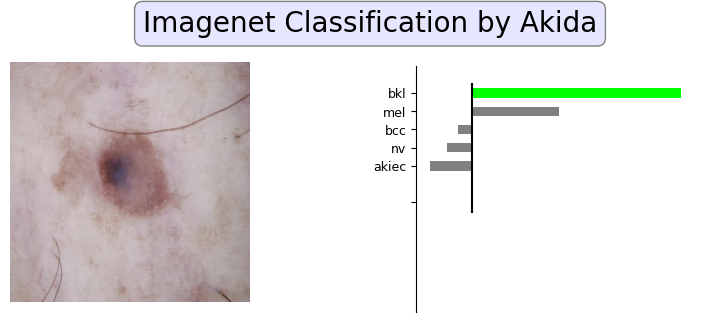

In [5]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from akida_models.imagenet import preprocessing
import numpy as np
from PIL import Image

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
classes = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = 224
NUM_CHANNELS = 3

# Functions used to display the top5 results
def get_top5(potentials, true_label):
    """
    Returns the top 5 classes from the output potentials
    """
    tmp_pots = potentials.copy()
    top5 = []
    min_val = np.min(tmp_pots)
    for ii in range(5):
        best = np.argmax(tmp_pots)
        top5.append(best)
        tmp_pots[best] = min_val

    vals = np.zeros((6,))
    vals[:5] = potentials[top5]

    if true_label not in top5:
        vals[5] = potentials[true_label]
    else:
        vals[5] = 0

    vals /= np.max(vals)

    class_name = []
    for ii in range(5):
        class_name.append(class_names[top5[ii]])
    if true_label in top5:
        class_name.append('')
    else:
        class_name.append(class_names[true_label])

    return top5, vals, class_name


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


def prepare_plots():
    fig = plt.figure(figsize=(8, 4))
    # Image subplot
    ax0 = plt.subplot(1, 3, 1)
    imgobj = ax0.imshow(np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), dtype=np.uint8))
    ax0.set_axis_off()
    # Top 5 results subplot
    ax1 = plt.subplot(1, 2, 2)
    bar_positions = (0, 1, 2, 3, 4, 6)
    rects = ax1.barh(bar_positions, np.zeros((6,)), align='center', height=0.5)
    plt.xlim(-0.2, 1.01)
    ax1.set(xlim=(-0.2, 1.15), ylim=(-1.5, 12))
    ax1.set_yticks(bar_positions)
    ax1.invert_yaxis()
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks([])
    adjust_spines(ax1, 'left')
    ax1.add_line(lines.Line2D((0, 0), (-0.5, 6.5), color=(0.0, 0.0, 0.0)))
    # Adjust Plot Positions
    ax0.set_position([0.05, 0.055, 0.3, 0.9])
    l1, b1, w1, h1 = ax1.get_position().bounds
    ax1.set_position([l1 * 1.05, b1 + 0.09 * h1, w1, 0.8 * h1])
    # Add title box
    plt.figtext(0.5,
                0.9,
                "Imagenet Classification by Akida",
                size=20,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round",
                          ec=(0.5, 0.5, 0.5),
                          fc=(0.9, 0.9, 1.0)))

    return fig, imgobj, ax1, rects


def update_bars_chart(rects, vals, true_label):
    counter = 0
    for rect, h in zip(rects, vals):
        rect.set_width(h)
        if counter < 5:
            if top5[counter] == true_label:
                if counter == 0:
                    rect.set_facecolor((0.0, 1.0, 0.0))
                else:
                    rect.set_facecolor((0.0, 0.5, 0.0))
            else:
                rect.set_facecolor('gray')
        elif counter == 5:
            rect.set_facecolor('red')
        counter += 1


def load_and_preprocess_image(image_path):
    """
    Loads and preprocesses the image to be fed into the model.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((64, 64))  
    img_array = np.array(img)
    return np.expand_dims(img_array.astype(np.uint8), axis=0)

def extract_true_label_from_path(image_path):
    """
    Extracts the true label from the image file path.
    Assumes the true label is the folder name just before the image file name.
    """
    true_label_name = os.path.basename(os.path.dirname(image_path))  
    if true_label_name in class_names:
        return class_names.index(true_label_name)
    else:
        raise ValueError(f"True label '{true_label_name}' not found in class names.")


# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Load image from file
image_path = 'archive/data/test/bkl/ISIC_0024445.jpg'  
image = load_and_preprocess_image(image_path)

# Predict image class
outputs_akida = model.predict(image).squeeze()

# Get top 5 prediction labels and associated names
true_label = extract_true_label_from_path(image_path)
top5, yvals, class_name = get_top5(outputs_akida, true_label)

print("Akida outputs:", outputs_akida)
print("True label:", class_names[true_label])
print("Predicted label:", class_names[np.argmax(outputs_akida)])

# Draw Plots
img = Image.open(image_path)
imgobj.set_data(img)
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()


In [6]:
model.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 7]     1          14    
______________________________________________

_________________________________________________________
Layer (type)           Output shape   Kernel shape     

=========== SW/conv2d_8-predictions (Software) ==========

conv2d_8 (InputConv.)  [64, 64, 32]   (3, 3, 3, 32)    
_________________________________________________________
conv2d_9 (Conv.)       [32, 32, 32]   (3, 3, 32, 32)   
_________________________________________________________
conv2d_10 (Conv.)      [32, 32, 64]   (3, 3, 32, 64)   
_________________________________________________________
conv2d_11 (Conv.)      [16, 16, 64]   (3, 3, 64, 64)   
_________________________________________________________
conv2d_12 (Conv.)      [16, 16, 128]  (3, 3, 64, 128)  
_________________________________________________________
conv2d_13 (Conv.)      [

# One-Shot Learning

Converting the akida model to support oneshot learning

In [7]:

from akida import AkidaUnsupervised
from akida import FullyConnected, SeparableConvolutional

# Replace the last layer by a classification layer
num_classes = 7
num_neurons_per_class = 500
num_weights = 512 # Refer to the bottom of working_cnn.ipynb for reason 
model.pop_layer()

# Akida needs a binary spiking layer and a binary fc layer
spike_generator = SeparableConvolutional(
            name='spike_gen',
            kernel_size=[3, 3],   
            filters=512,          
            kernel_stride=[1, 1], 
            weights_bits=1,       
        )

layer_fc = FullyConnected(name='akida_edge_layer',
                          units=num_classes * num_neurons_per_class,
                          activation=False)
model.add(spike_generator)
model.add(layer_fc)
model.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 3500]  1          15    
______________________________________________

_____________________________________________________________
Layer (type)               Output shape   Kernel shape     

========== SW/conv2d_8-akida_edge_layer (Software) ==========

conv2d_8 (InputConv.)      [64, 64, 32]   (3, 3, 3, 32)    
_____________________________________________________________
conv2d_9 (Conv.)           [32, 32, 32]   (3, 3, 32, 32)   
_____________________________________________________________
conv2d_10 (Conv.)          [32, 32, 64]   (3, 3, 32, 64)   
_____________________________________________________________
conv2d_11 (Conv.)          [16, 16, 64]   (3, 3, 64, 64)   
_____________________________________________________________
conv2d_12 (Conv.)          [16, 16, 128]  (3, 3, 64, 128)  
__________________________________

In [8]:
model.compile(optimizer=AkidaUnsupervised(num_weights=num_weights,
                                             num_classes=num_classes,
                                             learning_competition=0.1))

model.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 3500]  1          15    
______________________________________________

_____________________________________________________________
Layer (type)               Output shape   Kernel shape     

========== SW/conv2d_8-akida_edge_layer (Software) ==========

conv2d_8 (InputConv.)      [64, 64, 32]   (3, 3, 3, 32)    
_____________________________________________________________
conv2d_9 (Conv.)           [32, 32, 32]   (3, 3, 32, 32)   
_____________________________________________________________
conv2d_10 (Conv.)          [32, 32, 64]   (3, 3, 32, 64)   
_____________________________________________________________
conv2d_11 (Conv.)          [16, 16, 64]   (3, 3, 64, 64)   
_____________________________________________________________
conv2d_12 (Conv.)          [16, 16, 128]  (3, 3, 64, 128)  
__________________________________

In [9]:
akiec_path = 'archive/data/test/akiec/ISIC_0024468.jpg'
bcc_path = 'archive/data/test/bcc/ISIC_0024666.jpg'
bkl_path = 'archive/data/test/bkl/ISIC_0024412.jpg'
df_path = 'archive/data/test/df/ISIC_0025314.jpg'
mel_path = 'archive/data/test/mel/ISIC_0024310.jpg'
nv_path = 'archive/data/test/nv/ISIC_0024343.jpg'
vasc_path = 'archive/data/test/vasc/ISIC_0024402.jpg'

paths = [akiec_path, bcc_path, bkl_path, df_path, mel_path, nv_path, vasc_path]

for path in paths:
    image = load_and_preprocess_image(path)
    true_label = extract_true_label_from_path(path)
    model.fit(image, true_label)


## Adding new classes

In [10]:
# model = load_model('model_edge_trained.fbz')

model.add_classes(1)
new_image_path = 'scar/ISIC_5147305.jpg' # Replace with image uploader in the backend 
label = 'scar' # Replace with the label of the image in the backend

image = load_and_preprocess_image(new_image_path)
model.fit(image, len(class_names))
class_names.append(label)

Akida outputs: [0. 0. 0. ... 0. 0. 0.]
True label: bcc
Predicted label: akiec


C:\Users\Joo_Kai\AppData\Local\Temp\ipykernel_44628\737834484.py:34: RuntimeWarning: invalid value encountered in divide
  vals /= np.max(vals)


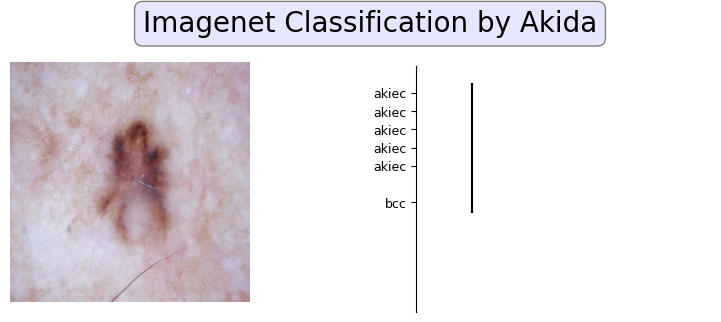

In [11]:
# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Load image from file
# image_path = 'scar/ISIC_8763306.jpg'
image_path = 'archive/data/test/bcc/ISIC_0024666.jpg'  
image = load_and_preprocess_image(image_path)

# Predict image class
outputs_akida = model.predict(image).squeeze()

# Get top 5 prediction labels and associated names
true_label = extract_true_label_from_path(image_path)
top5, yvals, class_name = get_top5(outputs_akida, true_label)

print("Akida outputs:", outputs_akida)
print("True label:", class_names[true_label])
print("Predicted label:", class_names[np.argmax(outputs_akida)])

# Draw Plots
img = Image.open(image_path)
imgobj.set_data(img)
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()